In [ ]:
cd /mnt/sda/otani/Experiments/moment_retrieval

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms, sentence2token
from src.toolbox.eval import evaluate, location_error, accumulate_metrics, categorize_results, summarize_results_per_class, predict
from src.toolbox.utils import _nms
from src.toolbox.visualization import plot_performance_per_class
from src.toolbox.data_converters import ActivityNetCap2Instances
import seaborn as sns
import pickle as pkl
import json

In [3]:
raw_data = json.load(open("data/raw/ActivityNet/val_2.json"))
test_data = ActivityNetCap2Instances(raw_data)

In [4]:
predictions = pkl.load(open("/home/otani_mayu/3TDisk/Experiments/SCDM/grounding/ActivityNet/result/scdm/76.pkl", "rb"), encoding='latin1')

In [5]:
def get_duration(video_id):
    for x in test_data:
        if x[0][0] == video_id:
            return x[1][-1]

def get_evaluation_results(predictions):
    preds = []
    for p in predictions:
        query = (p[0].decode('UTF-8'), p[2].decode('UTF-8'))
        video_duration = get_duration(query[0])
        seg = [s + [video_duration] for s in p[3][:5]]
        preds.append((query, seg, p[5][:5]))
    results = evaluate(test_data, preds)
    summary = accumulate_metrics(results)
    return results, summary

In [6]:
results, summary = get_evaluation_results(predictions)
pkl.dump(results,
    open("reports/figure_src/results/activitynet/scdm.pkl", "wb"))

-17129 missing instances
missing item: ('v_uqiMw7tQ1Cc', ' One man is holding onto a rope attached to a machine, and the other man instructs him to bend down on his left knee while still holding onto the rope and he showing the man how to have proper form.')
missing item: ('v_5qsXmDi8d74', 'The two sumo men are in the sumo ring with the referee in the middle of them off to the side and they begin to wrestle one another trying to push each other out of the ring while the referee runs from side to side to monitor the situations.')
missing item: ('v_5qsXmDi8d74', ' Eventually the taller sumo pushes the smaller guy out of the ring and they fall a little into the audience but both remain on their feet and go back onto the ring to catch their breaths and have the referee announce the winner.')
missing item: ('v_koEfnIoZB_4', '  A person wearing a bungee jumping harness and attached to a long rope jumps from the ledge of a stone tunnel and falls many feet below to just above the ground where 

In [7]:
f"{summary['R@1 IoU>0.5']*100:.2f}"

'35.86'

In [14]:
shuffle_predictions = pkl.load(
    open("/home/otani_mayu/3TDisk/Experiments/SCDM/grounding/ActivityNet/result/scdm/76.shuffle.pkl", "rb"),
    encoding='latin1'
)
shuffle_results, shuffle_summary = get_evaluation_results(shuffle_predictions)
pkl.dump(shuffle_results,
    open("reports/figure_src/results/activitynet/scdm_shuffle.pkl", "wb"))

151 missing instances
missing item: ('v_uqiMw7tQ1Cc', ' One man is holding onto a rope attached to a machine, and the other man instructs him to bend down on his left knee while still holding onto the rope and he showing the man how to have proper form.')
missing item: ('v_5qsXmDi8d74', 'The two sumo men are in the sumo ring with the referee in the middle of them off to the side and they begin to wrestle one another trying to push each other out of the ring while the referee runs from side to side to monitor the situations.')
missing item: ('v_5qsXmDi8d74', ' Eventually the taller sumo pushes the smaller guy out of the ring and they fall a little into the audience but both remain on their feet and go back onto the ring to catch their breaths and have the referee announce the winner.')
missing item: ('v_koEfnIoZB_4', '  A person wearing a bungee jumping harness and attached to a long rope jumps from the ledge of a stone tunnel and falls many feet below to just above the ground where the

In [15]:
f"{shuffle_summary['R@1 IoU>0.5']*100:.2f}"

'34.36'

Text(0.5, 1.0, 'failure')

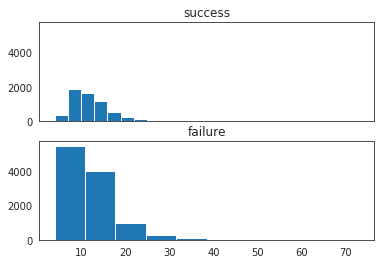

In [12]:
failure = []
success = []
for r, gt_dat in zip(results, test_data):
    (_, sentence), (s, e, l) = gt_dat
    n_words = len(sentence.split())
    is_succeed = r[-1]['R@1 IoU>0.5']
    if is_succeed:
        success.append(n_words)
    else:
        failure.append(n_words)

_, axes = plt.subplots(2, 1, sharex=True, sharey=True)
axes[0].hist(success)
axes[0].set_title("success")
axes[1].hist(failure)
axes[1].set_title("failure")

In [10]:
from collections import Counter
def get_key_tokens(sentences: List[str]):
    simplified_sentences = []

    for i, sentence in enumerate(sentences):
        key_tokens = sentence2token(sentence)
        simplified_sentences.append(key_tokens)
        
    return simplified_sentences

train_data = Charade2Instances(pd.read_csv('data/processed/train.csv'))

sentences = [query[1] for query, _ in train_data]
simplified_sentences = get_key_tokens(sentences)

verbs = sum([x[0] for x in simplified_sentences], [])
verb_c = Counter(verbs)
k = 50

counts = [v for _, v in verb_c.most_common(k)]
top_actions = [word for word, _ in verb_c.most_common(k)]

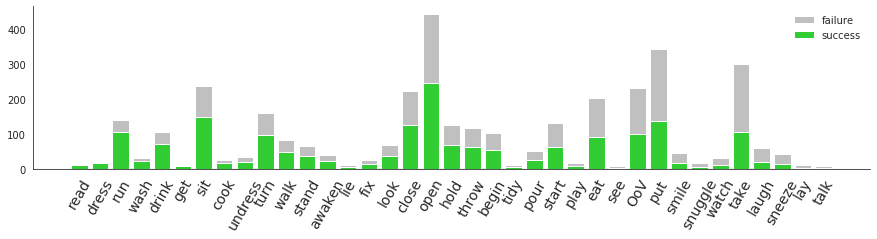

In [12]:
from src.toolbox.eval import get_first_action, categorize_results, summarize_results_per_class
from src.toolbox.utils import _load_top_actions
top_actions = _load_top_actions("charade")
cat_fn = lambda x: get_first_action(x, top_actions)
categorized_results = categorize_results(results, cat_fn)
metrics_per_cls = summarize_results_per_class(categorized_results)
pkl.dump(metrics_per_cls, open("reports/figure_src/metrics_per_cls/charade/scdm.pkl", "wb"))

metrics_per_cls = pkl.load(open("reports/figure_src/metrics_per_cls/charade/scdm.pkl", "rb"))
class_labels = list(metrics_per_cls.keys())
frequent_class = [label for label in class_labels if metrics_per_cls[label]["n_instance"] > 10]
_ = plot_performance_per_class({l: v for l, v in metrics_per_cls.items() if l in frequent_class})
plt.savefig("reports/figures/detailed_analysis/charade/performance_per_cls/scdm.pdf", bbox_inches="tight")

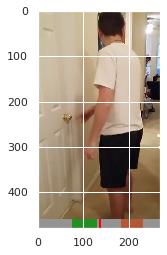

In [207]:
from skvideo.io import vread, vwrite
import matplotlib.colors as mcolors

i = np.random.randint(len(results))
res = results[i]
query, preds, _, metrics = res

if metrics['R@1 IoU>0.5'] == False:

    for gt_q, gt_location in test_data:
        if query == gt_q:
            break

    vid_arr = vread(f"data/raw/video/{query[0]}.mp4", inputdict={"-r": "10"})
    N, H, W, C = vid_arr.shape

    fps = N / gt_location[-1]

    pred_start_sec, pred_end_sec, duration = preds[0]
    gt_start_sec, gt_end_sec, _ = gt_location

    pred_start_i = pred_start_sec / duration * W
    pred_end_i = pred_end_sec / duration * W
    gt_start_i = gt_start_sec / duration * W
    gt_end_i = gt_end_sec / duration * W

    time_line = np.zeros((N, 20, W, C))
    time_line[:, :, int(pred_start_i):int(pred_end_i), :] += np.asarray(mcolors.to_rgb(mcolors.CSS4_COLORS["coral"])) * 255 * .7
    time_line[:, :, int(gt_start_i):int(gt_end_i), :] += np.asarray(mcolors.to_rgb(mcolors.CSS4_COLORS["limegreen"])) * 255 * .7
    time_line[np.where(time_line==0)] = 147.7
    step = 1 / N * W
    for n in range(N):
        time_line[n, :, int(step * n): int(step*n+3), :] = [255, 0, 0]

    vid_arr[:, -20:, :, :] = time_line
    plt.imshow(vid_arr[int(N/2)])
    print(gt_q, gt_location)

In [210]:
vwrite(f"reports/videos/charade/scdm/{query[0]}.mp4", vid_arr, outputdict={"-pix_fmt": "yuv420p"})

In [209]:
from IPython.display import Video

Video(f'http://localhost:8888/files/data/raw/video/{query[0]}.mp4')

('4PEL7', 'person walks into a room to sit on the couch.') (18.6, 23.7, 23.96)


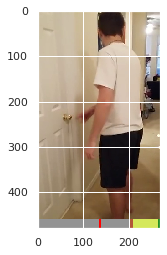

In [214]:
query = ("4PEL7", "person walks into a room to sit on the couch.")

for res in results:
    if res[0] == query:
        break
query, preds, _, metrics = res


for gt_q, gt_location in test_data:
    if query == gt_q:
        break

vid_arr = vread(f"data/raw/video/{query[0]}.mp4", inputdict={"-r": "10"})
N, H, W, C = vid_arr.shape

fps = N / gt_location[-1]

pred_start_sec, pred_end_sec, duration = preds[0]
gt_start_sec, gt_end_sec, _ = gt_location

pred_start_i = pred_start_sec / duration * W
pred_end_i = pred_end_sec / duration * W
gt_start_i = gt_start_sec / duration * W
gt_end_i = gt_end_sec / duration * W

time_line = np.zeros((N, 20, W, C))
time_line[:, :, int(pred_start_i):int(pred_end_i), :] += np.asarray(mcolors.to_rgb(mcolors.CSS4_COLORS["coral"])) * 255 * .7
time_line[:, :, int(gt_start_i):int(gt_end_i), :] += np.asarray(mcolors.to_rgb(mcolors.CSS4_COLORS["limegreen"])) * 255 * .7
time_line[np.where(time_line==0)] = 147.7
step = 1 / N * W
for n in range(N):
    time_line[n, :, int(step * n): int(step*n+3), :] = [255, 0, 0]

vid_arr[:, -20:, :, :] = time_line
plt.imshow(vid_arr[int(N/2)])
print(gt_q, gt_location)